In [1]:
import os
import csv
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm
from scipy.stats import sem
from matplotlib import cm
from scipy import stats
from scipy.stats import pearsonr
import ukbiobank.utils.utils
from ukbiobank.utils import loadCsv
from ukbiobank.utils import addFields
from ukbiobank.utils.utils import fieldIdsToNames
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

# Upload data

Instance 2 (first MRI visit)

In [ ]:
# Upload UK Bioabank csv
csv_path = '/UK_BB/ukbbdata/ukb.csv'
ukb = ukbiobank.ukbio(ukb_csv=csv_path)

In [68]:
# Upload required fields
df_cog = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',
20023, #RT: Mean time to correctly identify matches
4282, #Numeric memory: Maximum digits remembered correctly
20016, #Fluid intelligence: Fluid intelligence score
6348, #Trail making test: Duration to complete numeric path (trail #1)
6350, #Trail making test: Duration to complete alphanumeric path (trail #2)
6373, #Matrix pattern completion: Number of puzzles correctly solved
23324, #Symbol digit substitution: Number of correct matches
23323, #Symbol digit substitution: Number of symbol digit matches attempted
26302, #Picture vocabulary: Specific cognitive ability
21004, #Tower rearranging: Number of puzzles correct
20197, #Paired associate learning: Number of correct pairs
4292, #Prospective memory: Initial answer
399, #Pairs matching: Incorrect matches
20139 #Broken letter recognition: Number of letters correctly identified
])

The following variables were not found:
 [26302, 20139]. 

 This may be because the same fieldname is used across multiple field IDs.

 Either check the spelling of the variables or alternatively try using the field ID


In [ ]:
# Upload Picture Vocabulary and Broken Letter Recognition separately
fields_26302_20139 = pd.read_csv('/UK_BB/ukbbdata/ukb.csv', usecols=['eid', '26302-2.0', '26302-3.0', '20139-2.0', '20139-3.0'])
fields_26302_20139.columns = fields_26302_20139.columns.str.replace('20139', 'Broken letter recognition: Number of letters correct')
fields_26302_20139.columns = fields_26302_20139.columns.str.replace('26302', 'Picture vocabulary: Specific cognitive ability')

# Convert field ID to field name and merge to Picture Vocabulary and Broken Letter Recognition
cog = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_cog)
cog = cog.merge(fields_26302_20139, on = 'eid')
# Save
cog.to_csv('/UK_BB/brainbody/cognition/data/cogscores_raw.csv', index=False)

In [ ]:
# Filter Instance 2
cog = pd.read_csv('/UK_BB/brainbody/cognition/data/cogscores_raw.csv')
cog = cog[['eid'] + cog.filter(regex=r'2\.\d$').columns.tolist()]

# Remove Rounds 1 and 3 for Pairs Matching
cog = cog.drop(columns=['Number of incorrect matches in round (Field ID: 399)-2.1', 'Number of incorrect matches in round (Field ID: 399)-2.3'])

# Rename columns
cog.columns = cog.columns.str.replace('Maximum digits remembered correctly (Field ID: 4282)', 'Numeric memory: Maximum digits remembered correctly')
cog.columns = cog.columns.str.replace('Fluid intelligence score (Field ID: 20016)', 'Fluid intelligence score')
cog.columns = cog.columns.str.replace('Number of symbol digit matches made correctly (Field ID: 23324)', 'Symbol digit substitution: Number of correct matches')
cog.columns = cog.columns.str.replace('Mean time to correctly identify matches', 'Reaction time')
cog.columns = cog.columns.str.replace('Number of word pairs correctly associated', 'PAL: Number of correct pairs')
cog.columns = cog.columns.str.replace('Number of incorrect matches in round (Field ID: 399)', 'Pairs matching: Incorrect matches') 
cog.columns = cog.columns.str.replace('PM: initial answer', 'Prospective memory: Initial answer') 
cog.columns = cog.columns.str.replace('Duration to complete alphanumeric path (trail #2) (Field ID: 6350)', 'TMT: Duration to complete alphabetic path') 
cog.columns = cog.columns.str.replace('Duration to complete numeric path (trail #1) (Field ID: 6348)', 'TMT: Duration to complete numeric path')
cog.columns = cog.columns.str.replace('Number of symbol digit matches attempted (Field ID: 23323)', 'Symbol digit substitution: Number of matches attempted')

cog = cog.rename(columns = {'Number of puzzles correctly solved-2.0':'Matrix pattern completion: Number of puzzles correct-2.0',
                            'Number of puzzles correct-2.0':'Tower rearranging: Number of puzzles correct-2.0'})
# Save
cog.to_csv('/UK_BB/brainbody/cognition/data/cogscores_i2_renamed.csv', index=False)

Total: 502356 participants

In [15]:
# Display NA
cog.isna().sum().sort_values(ascending=False)

Broken letter recognition: Number of letters correct-2.0      490549
Picture vocabulary: Specific cognitive ability-2.0            468470
Tower rearranging: Number of puzzles correct-2.0              460865
Numeric memory: Maximum digits remembered correctly-2.0       459159
Matrix pattern completion: Number of puzzles correct-2.0      444533
Symbol digit substitution: Number of matches attempted-2.0    444526
Symbol digit substitution: Number of correct matches-2.0      444526
TMT: Duration to complete numeric path-2.0                    443971
TMT: Duration to complete alphabetic path-2.0                 443971
PAL: Number of correct pairs-2.0                              443971
Fluid intelligence score-2.0                                  432552
Reaction time-2.0                                             431805
Prospective memory: Initial answer-2.0                        431457
Pairs matching: Incorrect matches-2.2                         431433
eid                               

# 12 tests

In [ ]:
# Select 12 tests
cog_twelve = pd.read_csv('/UK_BB/brainbody/cognition/data/cogscores_i2_renamed.csv').drop(columns = ['Broken letter recognition: Number of letters correct-2.0']).dropna(axis=0)
cog_twelve.shape

(33119, 14)

# Inspect and clean the data

In [32]:
# Check negative values
print('Twelve\n', (cog_twelve < 0).sum().sort_values())

Twelve
 eid                                                             0
Pairs matching: Incorrect matches-2.2                           0
TMT: Duration to complete numeric path-2.0                      0
TMT: Duration to complete alphabetic path-2.0                   0
Matrix pattern completion: Number of puzzles correct-2.0        0
Fluid intelligence score-2.0                                    0
Reaction time-2.0                                               0
PAL: Number of correct pairs-2.0                                0
Tower rearranging: Number of puzzles correct-2.0                0
Symbol digit substitution: Number of matches attempted-2.0      0
Symbol digit substitution: Number of correct matches-2.0        0
Picture vocabulary: Specific cognitive ability-2.0              0
Prospective memory: Initial answer-2.0                          9
Numeric memory: Maximum digits remembered correctly-2.0       250
dtype: int64


### Replace negative values with NA

Prospective memory: Initial answer and Numeric memory: Maximum digits remembered correctly <0 (-1) mean 'Participant skipped/abandonded'

In [33]:
# Replace negative values with NA
cog_twelve = cog_twelve.mask(cog_twelve < 0, np.nan)
# Check negative values
print('Negative\n', (cog_twelve < 0).sum().sort_values())
# Check zeroes
print('Zeroes\n', (cog_twelve == 0).sum().sort_values())

Negative
 eid                                                           0
Pairs matching: Incorrect matches-2.2                         0
Numeric memory: Maximum digits remembered correctly-2.0       0
Prospective memory: Initial answer-2.0                        0
TMT: Duration to complete numeric path-2.0                    0
TMT: Duration to complete alphabetic path-2.0                 0
Matrix pattern completion: Number of puzzles correct-2.0      0
Fluid intelligence score-2.0                                  0
Reaction time-2.0                                             0
PAL: Number of correct pairs-2.0                              0
Tower rearranging: Number of puzzles correct-2.0              0
Symbol digit substitution: Number of matches attempted-2.0    0
Symbol digit substitution: Number of correct matches-2.0      0
Picture vocabulary: Specific cognitive ability-2.0            0
dtype: int64
Zeroes
 eid                                                              0
Numeri

1. Numeric memory: Maximum digits remembered correctly-2.0 - 0 - OK (no 0s)
2. Reaction time-2.0                                           -  0 - OK (no 0s)
3. Symbol digit substitution: Number of matches attempted-2.0  -  0 - OK (no 0s)
4. Picture vocabulary: Specific cognitive ability-2.0         -   1 - OK (can be 0: 'Value has been scaled to the range 0-1')
5. Matrix pattern completion: Number of puzzles correct-2.0    -  3 - OK (can be 0)
6. Fluid intelligence score-2.0                                -  13 - CANNOT BE 0

Fluid intelligence: *Participants who did not answer all of the questions within the allotted 2 minute limit are scored as zero for each of the unattempted questions. -1 represents "Not calculable due to unclean data"*

3. Symbol digit substitution: Number of correct matches-2.0    -  52  - OK (can be 0)

*0 represents "Did not make any correct matches"*


8. Tower rearranging: Number of puzzles correct-2.0           -   54 - OK (can be 0)
9. TMT: Duration to complete numeric path-2.0                 -   199  - CANNOT BE 0
10. PAL: Number of correct pairs-2.0                           -  413 - OK (can be 0)
11. TMT: Duration to complete alphabetic path-2.0             -   967  - CANNOT BE 0
12. Pairs matching: Incorrect matches-2.2                      -  2234 - OK (can be 0)
13. Prospective memory: Initial answer-2.0                     -  6064 - OK (can be 0)

### Replace 0 with NA

In [34]:
# Replace 0 with NA
cog_twelve['Fluid intelligence score-2.0'] = cog_twelve['Fluid intelligence score-2.0'].replace(0, np.nan)
cog_twelve['TMT: Duration to complete numeric path-2.0'] = cog_twelve['TMT: Duration to complete numeric path-2.0'].replace(0, np.nan)
cog_twelve['TMT: Duration to complete alphabetic path-2.0'] = cog_twelve['TMT: Duration to complete alphabetic path-2.0'].replace(0, np.nan)

# Drop NA
cog_twelve = cog_twelve.dropna(axis=0)

# Check zeroes
(cog_twelve == 0).sum().sort_values()

eid                                                              0
Numeric memory: Maximum digits remembered correctly-2.0          0
TMT: Duration to complete numeric path-2.0                       0
TMT: Duration to complete alphabetic path-2.0                    0
Fluid intelligence score-2.0                                     0
Reaction time-2.0                                                0
Symbol digit substitution: Number of matches attempted-2.0       0
Picture vocabulary: Specific cognitive ability-2.0               1
Matrix pattern completion: Number of puzzles correct-2.0         3
Tower rearranging: Number of puzzles correct-2.0                43
Symbol digit substitution: Number of correct matches-2.0        45
PAL: Number of correct pairs-2.0                               373
Pairs matching: Incorrect matches-2.2                         2196
Prospective memory: Initial answer-2.0                        5589
dtype: int64

## Prepare test scores

#### Prospective memory

- 0=Blue square
- 1=Pink star
- 2=Grey cross
- 3=Orange circle

Recode to 1 if the participant correctly touched the orange circle on the first attempt, and 0 if they touched any other shape

In [35]:
# Recode Prospective memory
cog_twelve["Prospective memory: Initial answer-2.0"] = cog_twelve["Prospective memory: Initial answer-2.0"].replace(1, 0)
cog_twelve["Prospective memory: Initial answer-2.0"] = cog_twelve["Prospective memory: Initial answer-2.0"].replace(2, 0)
cog_twelve["Prospective memory: Initial answer-2.0"] = cog_twelve["Prospective memory: Initial answer-2.0"].replace(3, 1)

print((cog_twelve == 0).sum().sort_values())

# Check minimum and maximum values
for col in cog_twelve.columns:
    print(f'{col} MIN', cog_twelve[col].min())
    print(f'{col} MAX', cog_twelve[col].max())

eid                                                              0
Numeric memory: Maximum digits remembered correctly-2.0          0
TMT: Duration to complete numeric path-2.0                       0
TMT: Duration to complete alphabetic path-2.0                    0
Fluid intelligence score-2.0                                     0
Reaction time-2.0                                                0
Symbol digit substitution: Number of matches attempted-2.0       0
Picture vocabulary: Specific cognitive ability-2.0               1
Matrix pattern completion: Number of puzzles correct-2.0         3
Tower rearranging: Number of puzzles correct-2.0                43
Symbol digit substitution: Number of correct matches-2.0        45
PAL: Number of correct pairs-2.0                               373
Pairs matching: Incorrect matches-2.2                         2196
Prospective memory: Initial answer-2.0                        5676
dtype: int64
eid MIN 1000054
eid MAX 6024614
Pairs matching: I

### Symbol digit substitution: compute the score by dividing correct answers by N attempted

In [36]:
# Calculate Symbol digit substitution score by dividing correct by attempted
cog_twelve['Symbol digit substitution: Proportion of correct matches'] = cog_twelve['Symbol digit substitution: Number of correct matches-2.0'] / cog_twelve['Symbol digit substitution: Number of matches attempted-2.0']
cog_twelve['Symbol digit substitution: Proportion of correct matches'] = cog_twelve['Symbol digit substitution: Proportion of correct matches'].round(2)
cog_twelve = cog_twelve.drop(columns=['Symbol digit substitution: Number of correct matches-2.0', 'Symbol digit substitution: Number of matches attempted-2.0'])

Rename and save variables

In [ ]:
cog_twelve.columns = cog_twelve.columns.str.replace(r'-2.*', '', regex=True)
cog_twelve = cog_twelve.reset_index(drop=True)
cog_twelve.to_csv('/UK_BB/brainbody/cognition/data/cogscores_12T_i2_raw.csv', index=False)

# Plot distributions and age dynamics

Data distribution

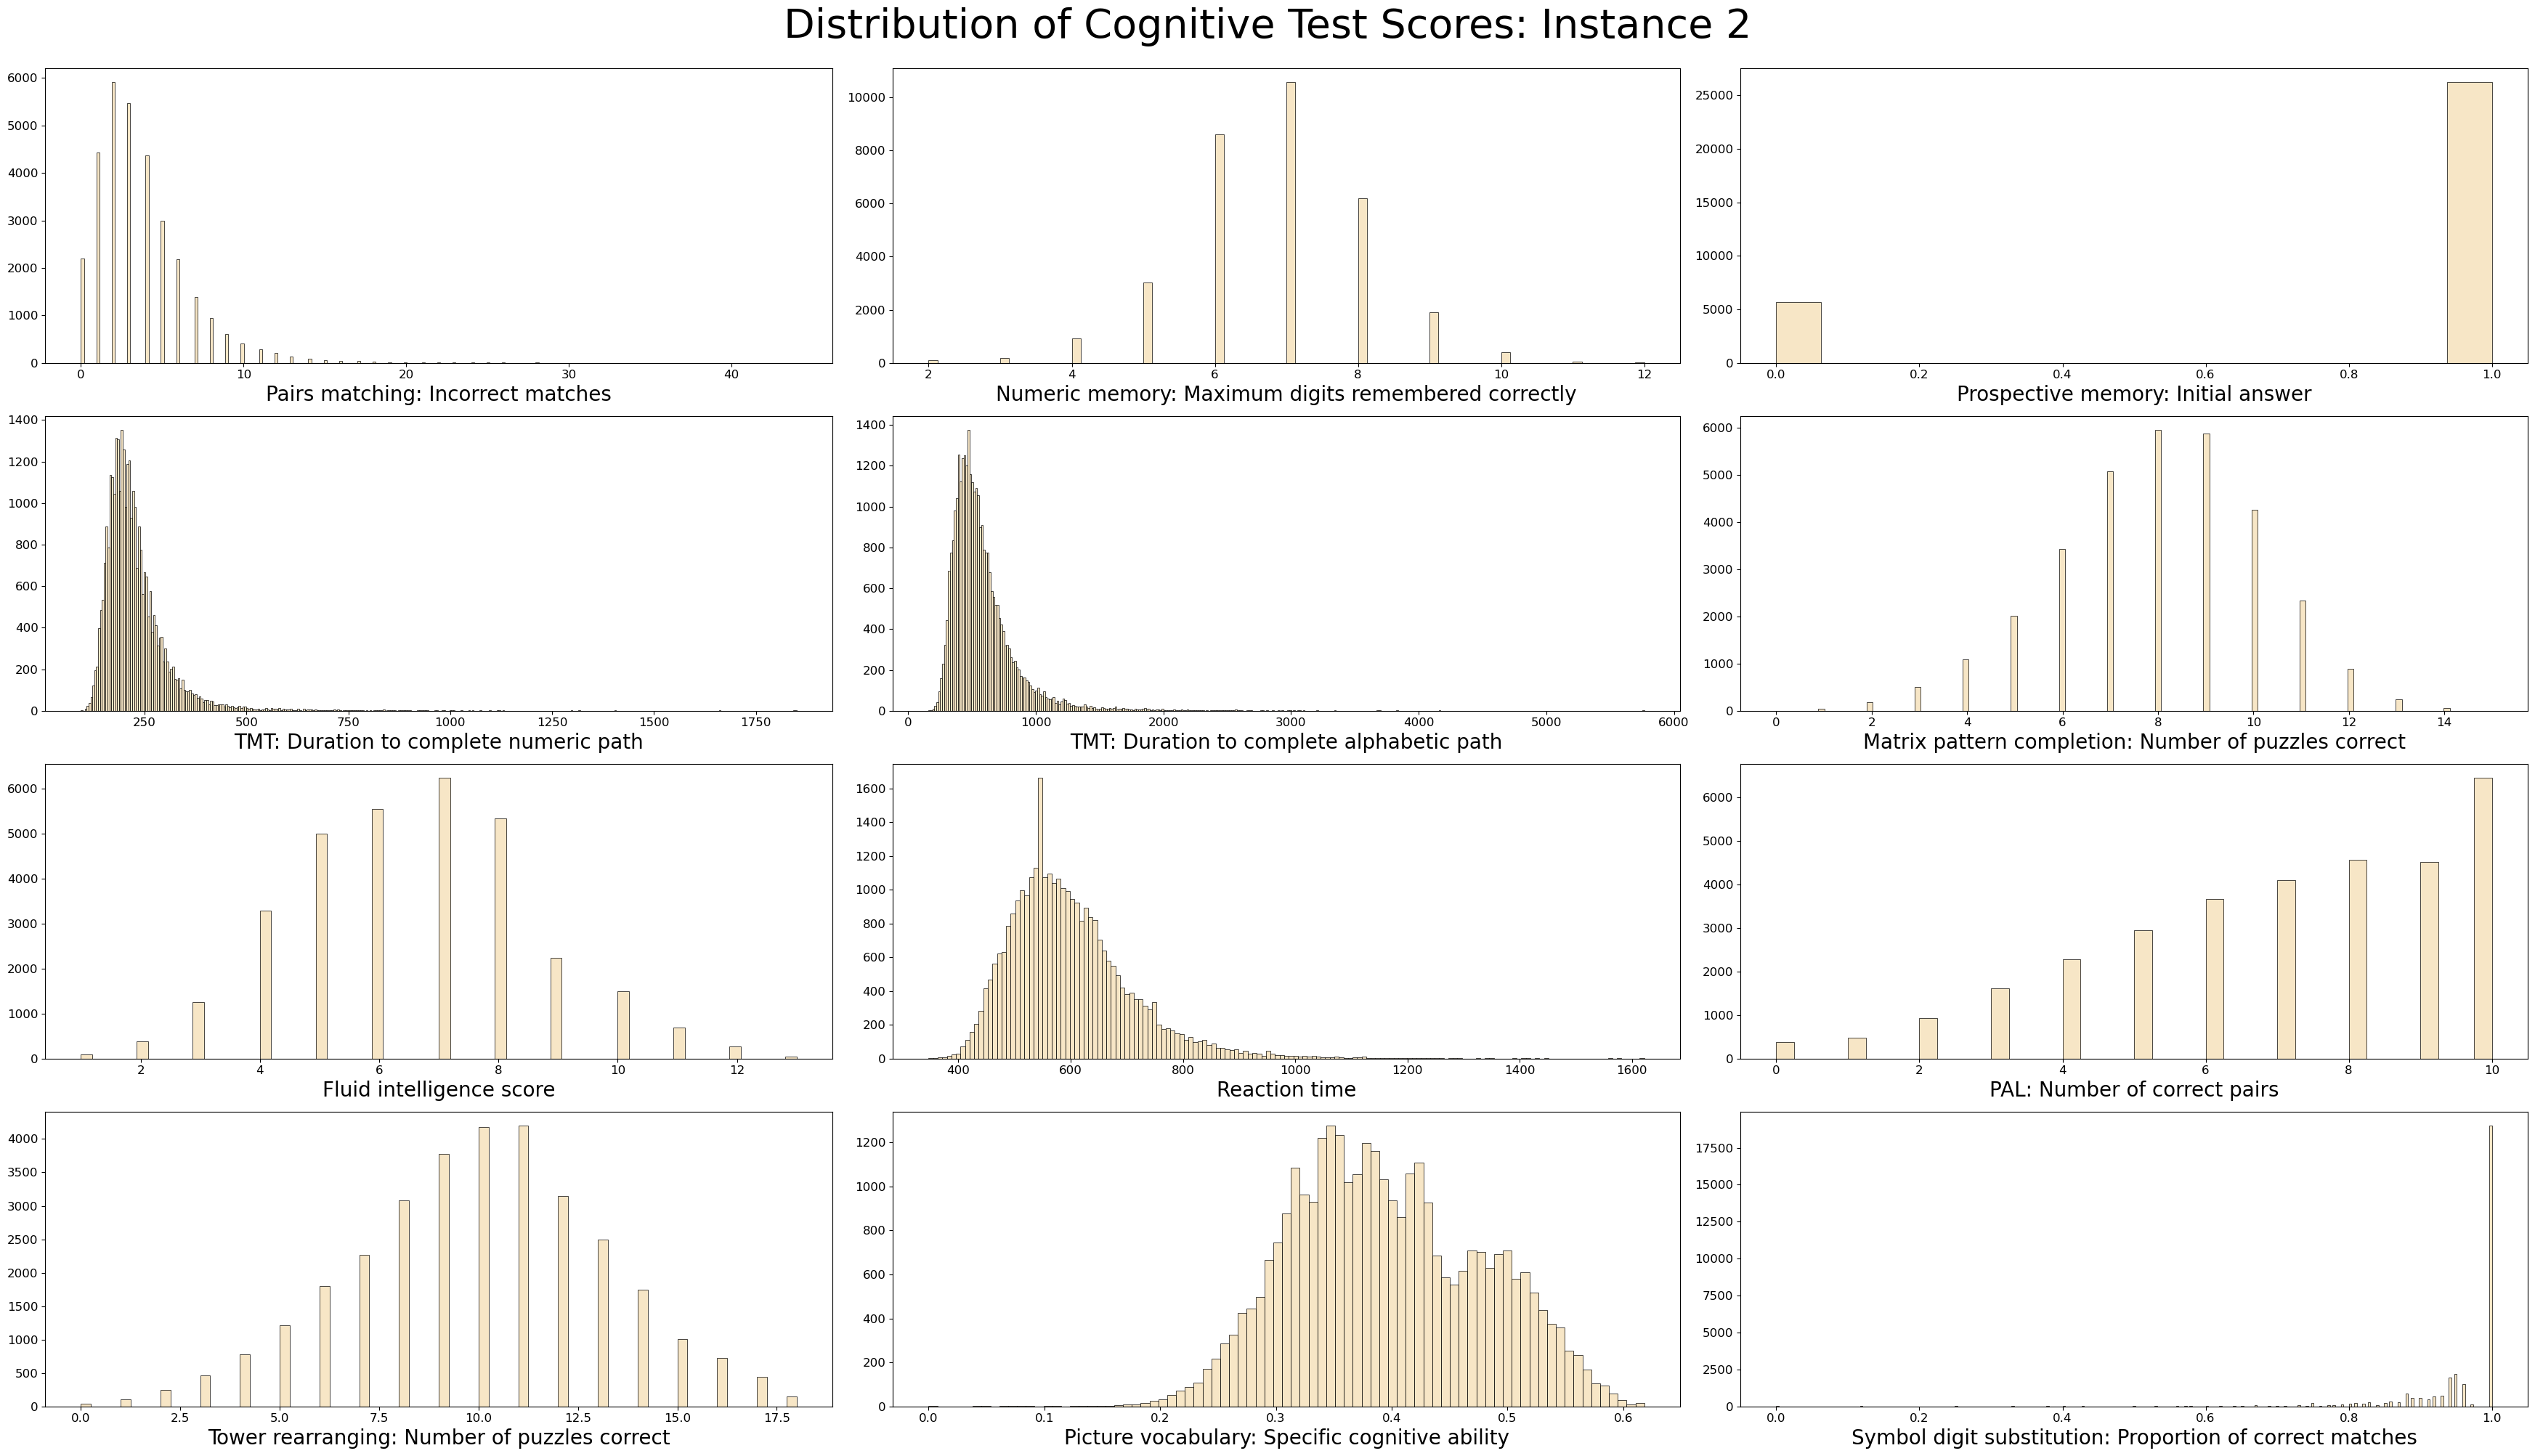

In [ ]:
# Cognitive test score distribution
cog_twelve_i2 = pd.read_csv('/UK_BB/brainbody/cognition/data/cogscores_raw_12T_i2.csv')
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(35, 20))
columns = cog_twelve_i2.drop(columns='eid').columns
axes = axes.flatten()
for i, col in enumerate(columns):

    sns.histplot(cog_twelve_i2.drop(columns='eid')[col], ax=axes[i], color='wheat', linewidth=0.5)

    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].set_xlabel(col, fontsize=20) 
    axes[i].set_ylabel(None) 
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].tick_params(axis='x', labelsize=12)

plt.suptitle('Distribution of Cognitive Test Scores: Instance 2', fontsize=40, y=1.0)
plt.subplots_adjust(hspace=0.6, wspace=0.5)
plt.tight_layout()
plt.show()

Age dynamics

In [ ]:
# Upload age
df_age = ukbiobank.utils.utils.loadCsv(ukbio=ukb, fields=['eid',21003])
age = ukbiobank.utils.utils.fieldIdsToNames(ukbio=ukb, df=df_age)
# Save
age.to_csv('/UK_BB/brainbody/age.csv', index=False)

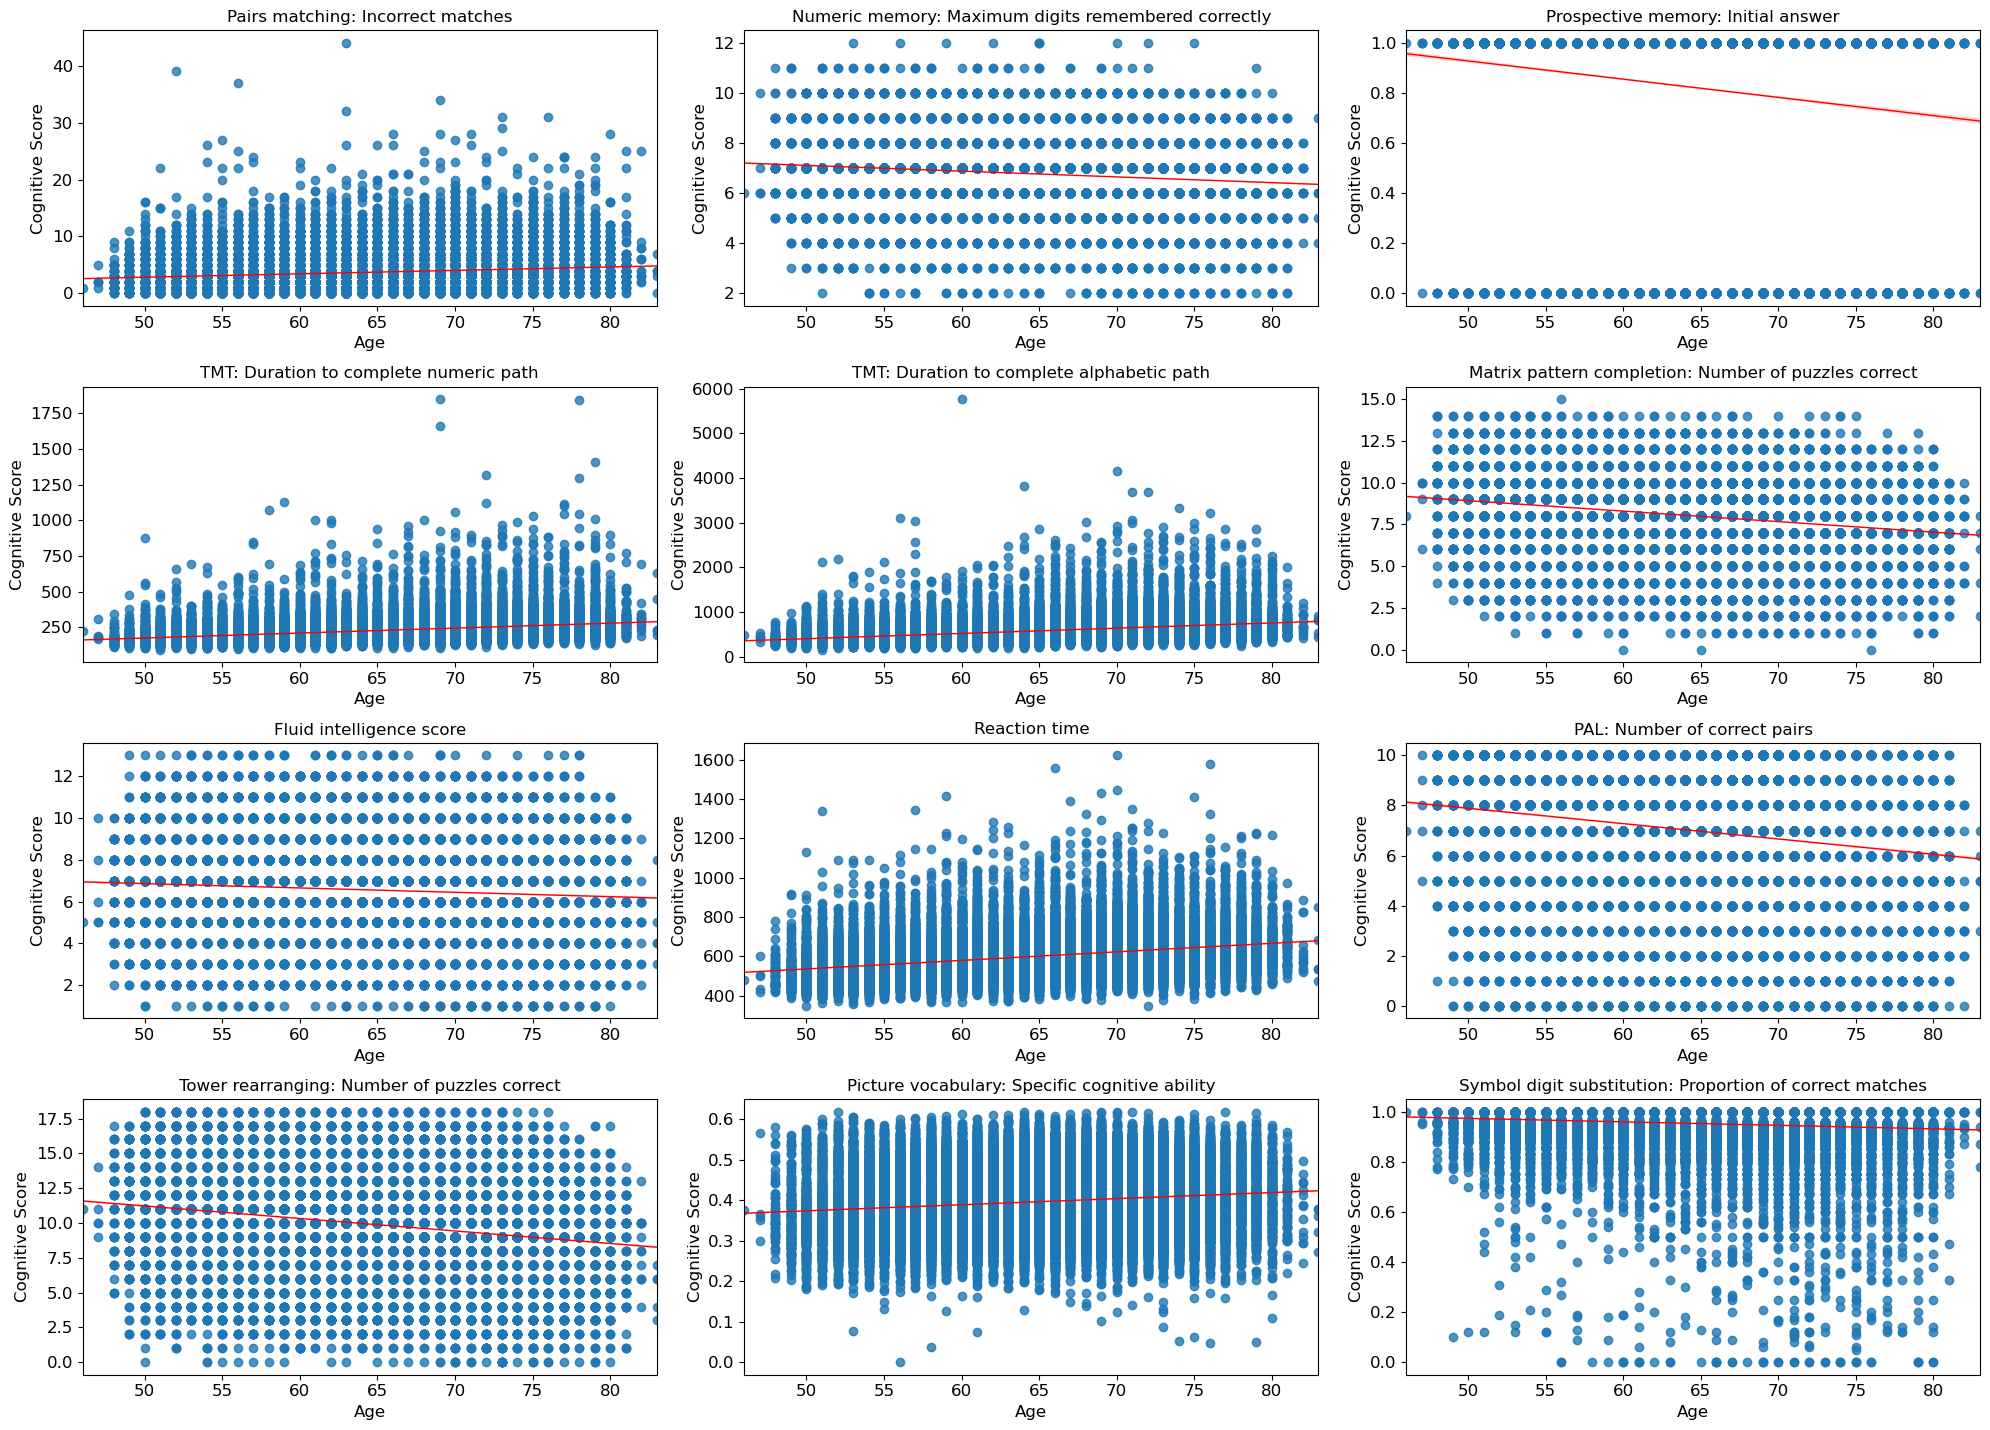

In [48]:
# Scatterplots of cognitive scores vs age
cog_twelve_i2_age = cog_twelve_i2.merge(age[['Age when attended assessment centre-2.0', 'eid']], on = 'eid')
cog_twelve_i2_age.columns = [col.split('-')[0] for col in cog_twelve_i2_age.columns]
columns = cog_twelve_i2_age.drop(columns=['eid', 'Age when attended assessment centre']).columns

fig, axes = plt.subplots(4, 3, figsize=(20, 15))
axes = axes.flatten()

for i, column in enumerate(columns):
    sns.regplot(x='Age when attended assessment centre', y=column, data=cog_twelve_i2_age, ax=axes[i], line_kws={'color': 'red', 'linewidth': 1})
    axes[i].set_xlabel('Age', fontsize=12)
    axes[i].set_ylabel('Cognitive Score', fontsize=12)
    axes[i].set_title(f'{column}', fontsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].grid(False)

#plt.suptitle('', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Transform scores

- log-transform time because it is skewed to 0 but is never 0
- log(x+1)-transform 'Pairs matching: Incorrect matches' because it is skewed to 0 but can also be 0

log(x+1)-transformation is recommended when data contain 0 or negative values, as the logarithm of zero is undefined

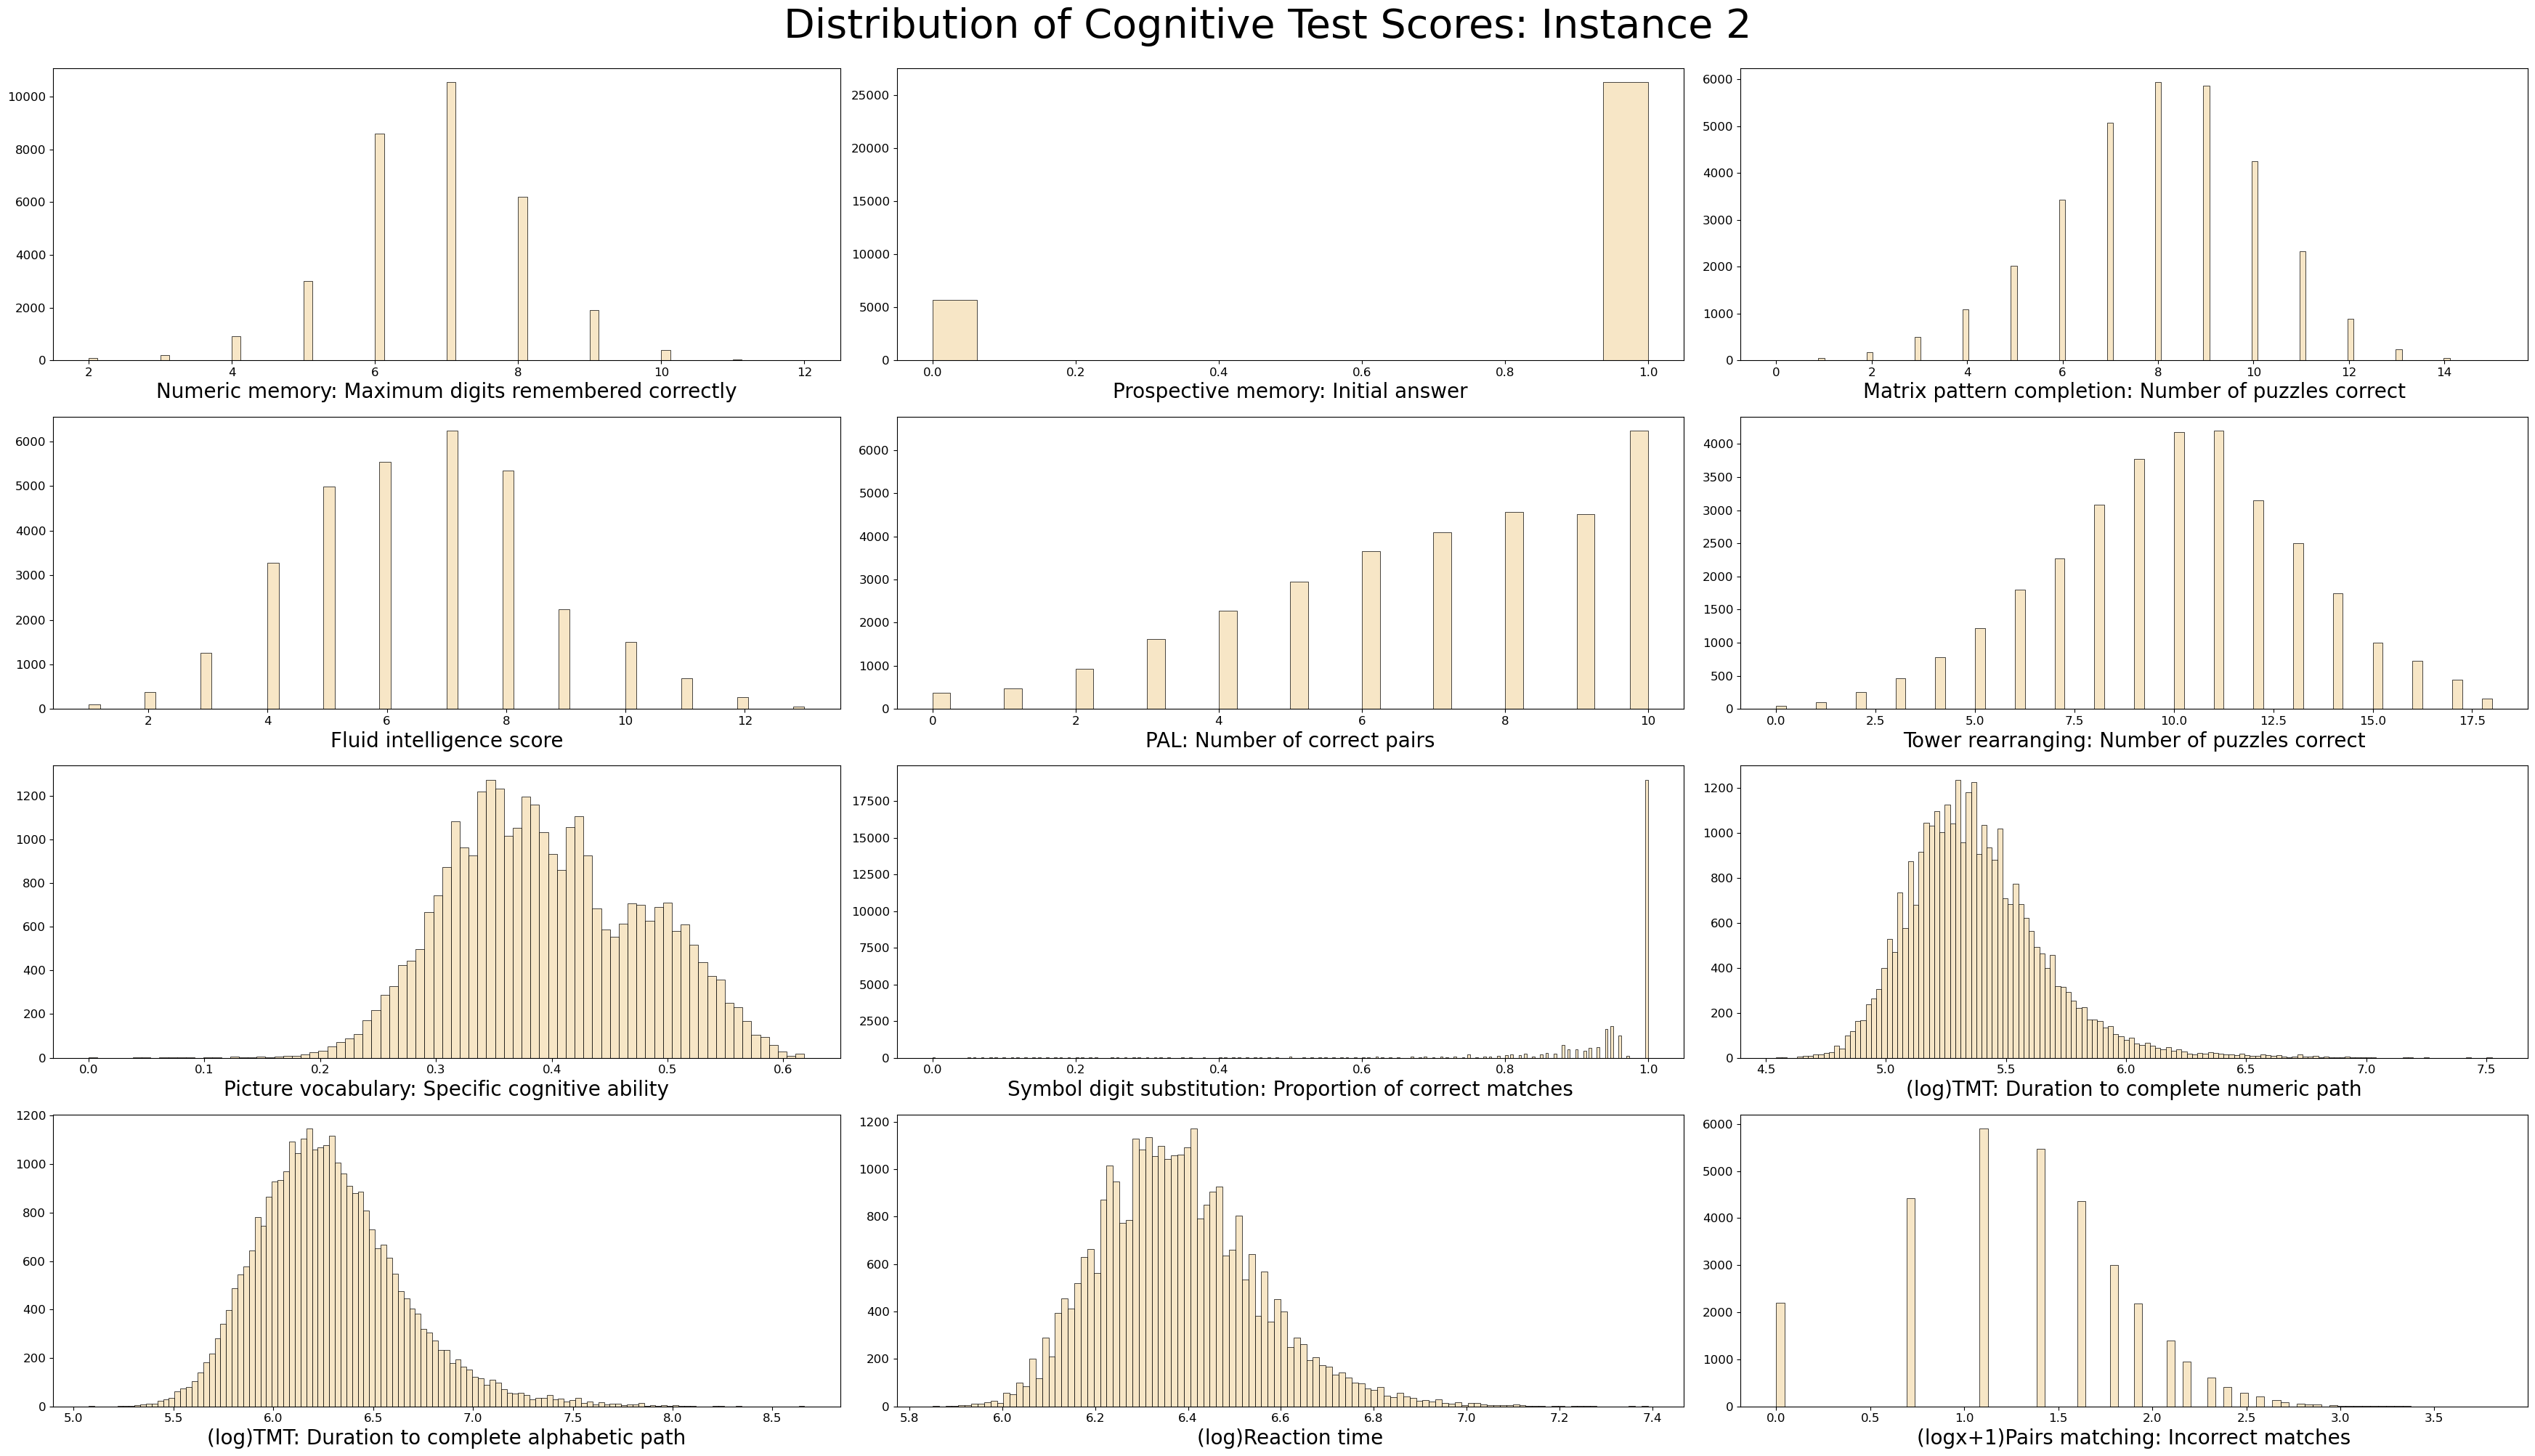

In [ ]:
cog_twelve_i2 = pd.read_csv('/UK_BB/brainbody/cognition/data/cogscores_12T_i2_raw.csv')
cog_twelve_i2_transformed = cog_twelve_i2.copy()
cog_twelve_i2_transformed['(log)TMT: Duration to complete numeric path'] = np.log(cog_twelve_i2_transformed['TMT: Duration to complete numeric path'])
cog_twelve_i2_transformed['(log)TMT: Duration to complete alphabetic path'] = np.log(cog_twelve_i2_transformed['TMT: Duration to complete alphabetic path'])
cog_twelve_i2_transformed['(log)Reaction time'] = np.log(cog_twelve_i2_transformed['Reaction time'])
cog_twelve_i2_transformed['(logx+1)Pairs matching: Incorrect matches'] = np.log1p(cog_twelve_i2_transformed['Pairs matching: Incorrect matches'])
cog_twelve_i2_transformed = cog_twelve_i2_transformed.drop(columns = [
'TMT: Duration to complete numeric path', 'TMT: Duration to complete alphabetic path', 'Reaction time', 'Pairs matching: Incorrect matches'])
cog_twelve_i2_transformed.to_csv('/UK_BB/brainbody/cognition/data/cogscores_12T_i2_transformed.csv', index=False)

# Plot
# Cognitive test score distribution
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(35, 20))
columns = cog_twelve_i2_transformed.drop(columns='eid').columns
axes = axes.flatten()
for i, col in enumerate(columns):

    sns.histplot(cog_twelve_i2_transformed.drop(columns='eid')[col], ax=axes[i], color='wheat', linewidth=0.5)

    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].set_xlabel(col, fontsize=20) 
    axes[i].set_ylabel(None) 
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].tick_params(axis='x', labelsize=12)

plt.suptitle('Distribution of Cognitive Test Scores: Instance 2', fontsize=40, y=1.0)
plt.subplots_adjust(hspace=0.6, wspace=0.5)
plt.tight_layout()
plt.show()

## Split dataset into 5 folds using KFold

In [ ]:
# Split the data set into train and test, using random folds, and save datasets and IDs for each split
cog_instance_2 = pd.read_csv('/UK_BB/brainbody/cognition/data/cogscores_12T_i2_transformed.csv')
kf = KFold(n_splits = 5, shuffle = True, random_state = 0)
directory = '/UK_BB/brainbody/cognition/folds'

for fold, (train_index, test_index) in enumerate(kf.split(np.array(cog_instance_2))):
    print("TRAIN:", train_index, "TEST:", test_index)
    y_train, y_test = np.array(cog_instance_2)[train_index], np.array(cog_instance_2)[test_index]
    y_train_df_i2, y_test_df_i2 = pd.DataFrame(y_train, columns = cog_instance_2.columns), pd.DataFrame(y_test, columns = cog_instance_2.columns)

    # Convert 'eid' to an integer
    y_train_df_i2['eid'] = y_train_df_i2['eid'].astype(int)
    y_test_df_i2['eid'] = y_test_df_i2['eid'].astype(int)

    # Save full data frame
    y_train_df_i2.to_csv(f'{directory}/fold_{fold}/cogscores/cogscores_12T_i2_train_with_id_fold_{fold}.csv', index=False)
    y_test_df_i2.to_csv(f'{directory}/fold_{fold}/cogscores/cogscores_12T_i2_test_with_id_fold_{fold}.csv', index=False)
    # Save without ID
    y_train_df_i2.drop(columns=['eid']).to_csv(f'/{directory}/fold_{fold}/cogscores/cogscores_12T_i2_train_fold_{fold}.csv', index=False)
    y_test_df_i2.drop(columns=['eid']).to_csv(f'{directory}/fold_{fold}/cogscores/cogscores_12T_i2_test_fold_{fold}.csv', index=False)
    # Save only ID
    pd.DataFrame(y_train_df_i2['eid'], columns = ['eid']).to_csv(f'{directory}/fold_{fold}/cogscores/cogscores_12T_i2_train_id_fold_{fold}.csv', index=False)
    pd.DataFrame(y_test_df_i2['eid'], columns = ['eid']).to_csv(f'{directory}/fold_{fold}/cogscores/cogscores_12T_i2_test_id_fold_{fold}.csv', index=False)

TRAIN: [    0     1     2 ... 31891 31893 31895] TEST: [    4     6     7 ... 31892 31894 31896]
TRAIN: [    1     2     3 ... 31893 31894 31896] TEST: [    0     8     9 ... 31878 31890 31895]
TRAIN: [    0     4     6 ... 31894 31895 31896] TEST: [    1     2     3 ... 31885 31891 31893]
TRAIN: [    0     1     2 ... 31894 31895 31896] TEST: [   11    21    23 ... 31861 31863 31868]
TRAIN: [    0     1     2 ... 31894 31895 31896] TEST: [   10    13    19 ... 31887 31888 31889]


### Standardize (center and scale) cognitive scores

In [ ]:
folds = range(0, 5)
directory = '/UK_BB/brainbody/cognition/folds'
for fold in folds:
    cog_train = pd.read_csv(f'{directory}/fold_{fold}/cogscores/cogscores_12T_i2_train_with_id_fold_{fold}.csv')
    cog_train_noid = cog_train.drop(columns=['eid'])
    cog_test = pd.read_csv(f'{directory}/fold_{fold}/cogscores/cogscores_12T_i2_test_with_id_fold_{fold}.csv')
    cog_test_noid = cog_test.drop(columns=['eid'])

    scaler = StandardScaler()

    # Train
    cog_train_scaled = pd.DataFrame(scaler.fit_transform(cog_train_noid), columns = cog_train_noid.columns)
    cog_train_scaled['eid'] = cog_train['eid']
    cog_train_scaled.to_csv(f'{directory}/fold_{fold}/cogscores/cogscores_12T_i2_train_with_id_scaled_fold_{fold}.csv', index=False)

    # Test
    cog_test_scaled = pd.DataFrame(scaler.transform(cog_test_noid), columns = cog_test_noid.columns)
    cog_test_scaled['eid'] = cog_test['eid']
    cog_test_scaled.to_csv(f'{directory}/fold_{fold}/cogscores/cogscores_12T_i2_test_with_id_scaled_fold_{fold}.csv', index=False)

Add 'eid' column to the g-factor

In [ ]:
folds = range(0, 5)
directory = '/UK_BB/brainbody/cognition/folds'
for fold in folds:
    g_train = pd.read_csv(f'{directory}/fold_{fold}/g/g_train_{fold}.csv')
    train_id = pd.read_csv(f'{directory}/fold_{fold}/cogscores/cogscores_12T_i2_train_id_fold_{fold}.csv')
    pd.concat([g_train, train_id], axis=1).to_csv(f'{directory}/fold_{fold}/g/g_train_with_id_{fold}.csv', index=False)

    g_test = pd.read_csv(f'{directory}/fold_{fold}/g/g_test_{fold}.csv')
    test_id = pd.read_csv(f'{directory}/fold_{fold}/cogscores/cogscores_12T_i2_test_id_fold_{fold}.csv')
    pd.concat([g_test, test_id], axis=1).to_csv(f'{directory}/fold_{fold}/g/g_test_with_id_{fold}.csv', index=False)

# EFA loadings

Extract and export loadings

In [ ]:
cog = pd.read_csv("/UK_BB/brainbody/cognition/folds/fold_0/cogscores/cogscores_12T_i2_train_with_id_scaled_fold_0.csv")
cog.columns.to_list()

['Numeric memory: Maximum digits remembered correctly',
 'Prospective memory: Initial answer',
 'Matrix pattern completion: Number of puzzles correct',
 'Fluid intelligence score',
 'PAL: Number of correct pairs',
 'Tower rearranging: Number of puzzles correct',
 'Picture vocabulary: Specific cognitive ability',
 'Symbol digit substitution: Proportion of correct matches',
 '(log)TMT: Duration to complete numeric path',
 '(log)TMT: Duration to complete alphabetic path',
 '(log)Reaction time',
 '(logx+1)Pairs matching: Incorrect matches',
 'eid']

In [ ]:
# Export and rename factor loading 
variable_name_mapping = {
    'Numeric.memory..Maximum.digits.remembered.correctly': 'Numeric memory: Maximum digits remembered correctly',
    'Prospective.memory..Initial.answer': 'Prospective memory: Initial answer',
    'Matrix.pattern.completion..Number.of.puzzles.correct': 'Matrix pattern completion: Number of puzzles correct',
    'Fluid.intelligence.score': 'Fluid intelligence score',
    'PAL..Number.of.correct.pairs': 'PAL: Number of correct pairs',
    'Tower.rearranging..Number.of.puzzles.correct': 'Tower rearranging: Number of puzzles correct',
    'Picture.vocabulary..Specific.cognitive.ability': 'Picture vocabulary: Specific cognitive ability',
    'Symbol.digit.substitution..Proportion.of.correct.matches': 'Symbol digit substitution: Proportion of correct matches',
    'X.log.TMT..Duration.to.complete.numeric.path': '(log)TMT: Duration to complete numeric path',
    'X.log.TMT..Duration.to.complete.alphabetic.path': '(log)TMT: Duration to complete alphabetic path',
    'X.log.Reaction.time': '(log)Reaction time',
    'X.logx.1.Pairs.matching..Incorrect.matches': '(logx+1)Pairs matching: Incorrect matches'
}

# Set output path
output_path = '/UK_BB/brainbody/cognition/code/efa_loadings/efa_loadings_renamed.xlsx'

# Create Excel writer
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    for i in range(0, 5):  # Process groups 0-4
        try:
            # Read CSV
            file_path = f'/UK_BB/brainbody/cognition/code/efa_loadings/loadings_{i}.csv'
            df = pd.read_csv(file_path)
            
            # Rename variables if 'Variable' column exists
            if 'Variable' in df.columns:
                df['Variable'] = df['Variable'].replace(variable_name_mapping)
            
            # Write to Excel with sheet name
            df.to_excel(
                writer,
                sheet_name=f'Group_{i}',
                index=False
            )
            
            print(f"Successfully processed Group {i}")
            
        except FileNotFoundError:
            print(f"Warning: File loadings_{i}.csv not found - skipping")
            continue

print(f"\nAll renamed loadings successfully exported to:\n{output_path}")